In [1]:
import pickle
import pandas as pd
def getDF(tumor_type):
    filename = '../tcga/dense_features/'+tumor_type + '_list_v2.pkl'
    with open(filename, 'rb') as f:
        newlist = pickle.load(f, encoding='latin1')#, protocol=0)
        print('pickle loadded')
    flat_list = [item.T for sublist in newlist for item in sublist]
    ar = [df.loc[:,~df.columns.duplicated()] for df in flat_list]
    df = pd.concat(ar)
    return df

In [2]:
print('reading lgg')
lgg_data = getDF('lgg')
print('reading gbm')
gbm_data = getDF('gbm')
print('gbm and lgg read')
gbm_data['IS_GBM'] = 1
lgg_data['IS_GBM'] = 0
data =  pd.concat([gbm_data, lgg_data])
print('GBM shape:' + str(gbm_data.shape) + 'LGG shape:' + str(lgg_data.shape) + 'All shape:' + str(data.shape))

reading lgg
pickle loadded
reading gbm
pickle loadded
gbm and lgg read
GBM shape:(56308, 28)LGG shape:(39274, 28)All shape:(95582, 28)


In [4]:
#data =  pd.concat([gbm_data, lgg_data])
#print('GBM shape:' + str(gbm_data.shape) + 'LGG shape:' + str(lgg_data.shape) + 'All shape:' + str(data.shape))
data.columns

Index(['Age (years at diagnosis)', 'Case', 'Gender', 'Grade', 'ID', 'IS_GBM',
       'IntensityAverage', 'IntensityAverageWeakAndPositive',
       'IntensitySumPositive', 'IntensitySumStrongPositive',
       'IntensitySumWeakPositive', 'MGMT promoter status', 'NumberPositive',
       'NumberStrongPositive', 'NumberWeakPositive', 'RatioStrongToTotal',
       'Shape.Circularity', 'Shape.Eccentricity', 'Shape.EquivalentDiameter',
       'Shape.Extent', 'Shape.MinorMajorAxisRatio', 'Shape.Solidity',
       'Size.Area', 'Size.MajorAxisLength', 'Size.MinorAxisLength',
       'Size.Perimeter', 'Survival (months)', 'Vital status (1=dead)'],
      dtype='object')

In [59]:
X_orig = data[['Size.Area', 'Size.MajorAxisLength', 'Size.MinorAxisLength',\
         'Size.Perimeter',  'Shape.Circularity', 'Shape.Eccentricity',\
        'Shape.EquivalentDiameter', 'Shape.Extent', 'Shape.MinorMajorAxisRatio',\
        'Shape.Solidity', 'Age (years at diagnosis)', 'Gender', \
          "NumberWeakPositive", "NumberPositive", "NumberStrongPositive",\
          "IntensitySumWeakPositive", "IntensitySumPositive", "IntensitySumStrongPositive",\
          "IntensityAverage", "RatioStrongToTotal", "IntensityAverageWeakAndPositive"]]
X = X_orig.fillna(X_orig.mean())
X = (X - X.mean()) / (X.max() - X.min())
X.shape

(95582, 21)

x_train size: 86023
Logistic L1 classifier predicting tumor type; score: 0.8780207134637514
Logistic L1, alpha 0.005 classifier predicting tumor type; score: 0.8086619939324197
Logistic L2 classifier predicting tumor type; score: 0.8343969034417826
Decision tree, depth 3 classifier predicting tumor type; score: 0.8244586253792238
Random Forest classifier predicting tumor type; score: 0.8301077518568888
Naive Bayes classifier predicting tumor type; score: 0.5418976880426822


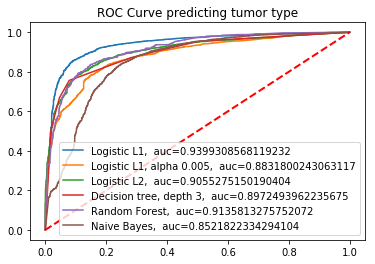

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, naive_bayes
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import json
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

y = data[['IS_GBM']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
lgst = LogisticRegression()
lasso = Lasso(alpha=0.1)
print("x_train size: " + str(len(x_train)))
def fitLinear(lr, clf_name):
    lr.fit(x_train, y_train)
    score = lr.score(x_test, y_test)
    print(clf_name + " classifier predicting tumor type; score: " +str(score))
    try:
        y_pred_proba = lr.predict_proba(x_test)[::,1]
        fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        return fpr, tpr, auc, lr
    except Exception as e:
        print(e)
        try:
            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)
        except exception as e:
            print(e)

clfs = {"Logistic L1": LogisticRegression(penalty="l1"),#SGDClassifier(loss='log',penalty="l1", alpha=0.0001),
        "Logistic L1, alpha 0.005":SGDClassifier(loss='log',penalty="l1", alpha=0.005),
        "Logistic L2": LogisticRegression(),\
        #"SVC":svm.SVC(probability=True),\
        "Decision tree, depth 3": DecisionTreeClassifier(max_depth=3),
        "Random Forest": RandomForestClassifier(max_depth=3),
        "Naive Bayes": naive_bayes.GaussianNB()
       }#, min_samples_leaf=0.1)}}#, min_samples_leaf=0.1)}

for name, clf in clfs.items():
    fpr, tpr, auc, clf = fitLinear(clf, name)
    plt.plot(fpr,tpr,label=name + ",  auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("ROC Curve predicting tumor type")
plt.show()

In [74]:
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
best_clf = clfs["Logistic L1"]
y_test_np = np.asarray(y_test.T)
misclassified = np.where(y_test_np != best_clf.predict(x_test))
b = x_test.loc[misclassified]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 411, in execute_request
    reply_content = json_clean(reply_content)
  File "/home/shared/anaconda3

Normalized confusion matrix
[[0.83268076 0.16731924]
 [0.10439944 0.89560056]]


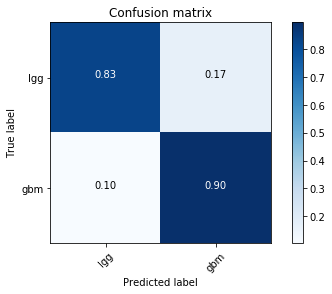

In [8]:
best_clf_preds = clfs["Logistic L1"].predict(x_test)
cm = confusion_matrix(y_test, best_clf_preds)
plot_confusion_matrix(cm, classes=['lgg', 'gbm'], normalize=True)

In [9]:
lgg_data.shape, gbm_data.shape

((39274, 28), (56308, 28))

In [10]:
import pprint
def print_coeffs_labeled(clf):
    coeff_values = clf.coef_.flatten()
    coeffs = []
    for i, col in enumerate(X.columns):
        coeffs.append((coeff_values[i], col))
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(sorted(coeffs, key=lambda x: abs(x[0]), reverse=True))

for name, clf in clfs.items():
    try:
        print(name)
        print_coeffs_labeled(clf)
    except:
        pass


Logistic L1
[   (478.37788963638735, 'Shape.EquivalentDiameter'),
    (-187.33858545480132, 'Size.MinorAxisLength'),
    (-170.42650834996826, 'Size.Perimeter'),
    (-62.00095195254094, 'Size.MajorAxisLength'),
    (57.55621834609819, 'IntensitySumPositive'),
    (40.21832928172148, 'Shape.Circularity'),
    (23.643490954207465, 'NumberStrongPositive'),
    (-21.55821080753001, 'NumberPositive'),
    (-8.547064300410298, 'NumberWeakPositive'),
    (-7.470382071749741, 'IntensityAverageWeakAndPositive'),
    (6.666988529102091, 'IntensityAverage'),
    (5.555128515534229, 'Age (years at diagnosis)'),
    (3.8791102172055454, 'Shape.MinorMajorAxisRatio'),
    (3.68945649907086, 'Shape.Eccentricity'),
    (-1.5503408889813606, 'Shape.Solidity'),
    (1.4060910409137213, 'Shape.Extent'),
    (-0.3347366686886678, 'RatioStrongToTotal'),
    (0.21492477487643782, 'Gender'),
    (0.0, 'Size.Area'),
    (0.0, 'IntensitySumWeakPositive'),
    (0.0, 'IntensitySumStrongPositive')]
Logistic L1, a

In [50]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
y = data[['Survival (months)']]
y = y.fillna(60)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

survival_predictors = {"Linear L2": LinearRegression(),\
                       "Lasso1": Lasso(),\
                       "Lasso0.5": Lasso(alpha=0.5)
       }

for name, lr in survival_predictors.items():
    lr.fit(x_train, y_train)
    score = lr.score(x_test, y_test)
    print("Using "+ str(name) +" to predict survival. Score: " + str(score))
    
poly = PolynomialFeatures(degree=2)
quad = LinearRegression()
x_train_, x_test_ = poly.fit_transform(x_train), poly.fit_transform(x_test)
quad.fit(x_train_, y_train)
score = quad.score(x_test_, y_test)
print("Using degree "+ str(degree) +" regression to predict survival. Score: " + str(score))

quad_L1 = Lasso()
x_train_, x_test_ = poly.fit_transform(x_train), poly.fit_transform(x_test)
quad_L1.fit(x_train_, y_train)
score = quad_L1.score(x_test_, y_test)
print("Using degree "+ str(degree) +" regression with Lasso to predict survival. Score: " + str(score))

Using Linear L2 to predict survival. Score: 0.11063999809901094
Using Lasso1 to predict survival. Score: 0.06148860708429459
Using Lasso0.5 to predict survival. Score: 0.09510224875002593
Using degree 2 regression to predict survival. Score: 0.1946732501295696
Using degree 2 regression with Lasso to predict survival. Score: 0.06148860708429459


In [49]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
y = data[['Survival (months)']]
y = y.fillna(60)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

survival_predictors = {"Linear L2": LinearRegression(),\
                       "Lasso1": Lasso(),\
                       "Lasso0.5": Lasso(alpha=0.5)
       }

for name, lr in survival_predictors.items():
    lr.fit(x_train, y_train)
    score = lr.score(x_test, y_test)
    print("Using "+ str(name) +" to predict n_mutations. Score: " + str(score))
    
poly = PolynomialFeatures(degree=2)
quad = LinearRegression()
x_train_, x_test_ = poly.fit_transform(x_train), poly.fit_transform(x_test)
quad.fit(x_train_, y_train)
score = quad.score(x_test_, y_test)
print("Using degree "+ str(degree) +" regression to predict n_mutations. Score: " + str(score))

quad_L1 = Lasso()
x_train_, x_test_ = poly.fit_transform(x_train), poly.fit_transform(x_test)
quad_L1.fit(x_train_, y_train)
score = quad_L1.score(x_test_, y_test)
print("Using degree "+ str(degree) +" regression with Lasso to predict n_mutations. Score: " + str(score))

AttributeError: 'LinearRegression' object has no attribute '_coefs'

In [33]:
print_coeffs_labeled(quad)

[   (3427160259692.511, 'IntensitySumPositive'),
    (-3408881803634.4536, 'NumberStrongPositive'),
    (-2974400255601.0522, 'NumberPositive'),
    (2054182223114.0723, 'IntensitySumStrongPositive'),
    (2025134624541.323, 'IntensitySumWeakPositive'),
    (94154063607.5852, 'IntensityAverage'),
    (-24940521482.117756, 'IntensityAverageWeakAndPositive'),
    (-22592295644.749874, 'RatioStrongToTotal'),
    (712.3333712695857, 'Size.MajorAxisLength'),
    (-457.2347487163886, 'Shape.Extent'),
    (166.39692935170578, 'Size.Perimeter'),
    (130.05636952072243, 'Shape.Circularity'),
    (80.52923273133244, 'Shape.Eccentricity'),
    (-45.391828458171645, 'Shape.MinorMajorAxisRatio'),
    (-39.23454003282609, 'Gender'),
    (-29.900801725643397, 'Shape.EquivalentDiameter'),
    (-25.752380512537457, 'NumberWeakPositive'),
    (-23.81792625983215, 'Shape.Solidity'),
    (21.22998410939391, 'Age (years at diagnosis)'),
    (-17.090182046570852, 'Size.MinorAxisLength'),
    (1.78480422666

AttributeError: 'LinearRegression' object has no attribute 'f_pvalue'

In [12]:
y = data[['Grade']]
X = X.fillna(1)
y = y.fillna(1000)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clfs = {"Logistic L1": LogisticRegression(penalty="l1"),#SGDClassifier(loss='log',penalty="l1", alpha=0.0001),
       # "Logistic L1, alpha 0.005":SGDClassifier(loss='log',penalty="l1", alpha=0.005),
        "Logistic L2": LogisticRegression(),\
        #"SVC":svm.SVC(probability=True),\
        "Decision tree, depth 3": DecisionTreeClassifier(max_depth=3),
        "Random Forest": RandomForestClassifier(max_depth=3),
        "Naive Bayes": naive_bayes.GaussianNB()
       }#, min_samples_leaf=0.1)}}#, min_samples_leaf=0.1)}

for name, clf in clfs.items():
    print(name)
    fitLinear(clf, name)
    #plt.plot(fpr,tpr,label=name + ",  auc="+str(auc))
'''
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("ROC Curve predicting tumor type")
plt.show()
'''

'''
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
lr = LogisticRegression()
lr.fit(x_train, y_train)
#predictions_type = lr.predict(x_test)
score = lr.score(x_test, y_test)
print("score: "+ str(score) + " predicting survival, with x_train size " + str(len(x_train)))
grades = data[['Grade']].fillna(-1).as_matrix()
l = grades.squeeze().tolist()
import collections
collections.Counter(l)
#from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
#y_pred_proba = lr.predict_proba(x_test)[::,1]
'''

Logistic L1
Logistic L1 classifier predicting tumor type; score: 0.6919133800606758
multiclass format is not supported
Logistic L2
Logistic L2 classifier predicting tumor type; score: 0.6592739826341667
multiclass format is not supported
Decision tree, depth 3
Decision tree, depth 3 classifier predicting tumor type; score: 0.6874150015692018
multiclass format is not supported
Random Forest
Random Forest classifier predicting tumor type; score: 0.6518464274505702
multiclass format is not supported
Naive Bayes
Naive Bayes classifier predicting tumor type; score: 0.4189768804268229
multiclass format is not supported


'\nx_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)\nlr = LogisticRegression()\nlr.fit(x_train, y_train)\n#predictions_type = lr.predict(x_test)\nscore = lr.score(x_test, y_test)\nprint("score: "+ str(score) + " predicting survival, with x_train size " + str(len(x_train)))\ngrades = data[[\'Grade\']].fillna(-1).as_matrix()\nl = grades.squeeze().tolist()\nimport collections\ncollections.Counter(l)\n#from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score\n#y_pred_proba = lr.predict_proba(x_test)[::,1]\n'

Normalized confusion matrix
[[0.45395514 0.25501771 0.29102715 0.        ]
 [0.24027704 0.45764518 0.30207778 0.        ]
 [0.03570757 0.02762639 0.93666604 0.        ]
 [0.03748126 0.22338831 0.73613193 0.0029985 ]]


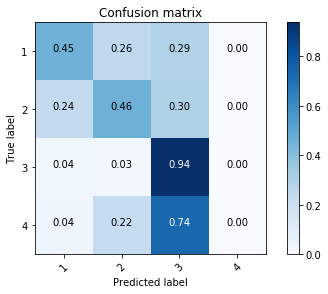

In [23]:
best_clf_preds = clfs["Logistic L1"].predict(x_test)
cm = confusion_matrix(y_test, best_clf_preds)
plot_confusion_matrix(cm, classes=['1', '2', '3','4'], normalize=True)

In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
def get_img(tumor_type, idx, res=256):
    im_dir = '../tcga/'+str(res)+'/train/' + tumor_type + '/'
    imgs = [im_dir + imname for imname in os.listdir(im_dir)]
    img = plt.imread(imgs[idx])
    mask = img < 1.0
    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)

    # Bounding box of non-black pixels.
    x0, y0, intensity = coords.min(axis=0)
    x1, y1, intensity = coords.max(axis=0) + 1   # slices are exclusive at the top

    # Get the contents of the bounding box.
    cropped = img[x0:x1, y0:y1]
    return cropped

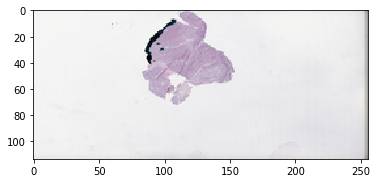

In [15]:
a = get_img('gbm', 20)
mask = a < 1.0
# Coordinates of non-black pixels.
coords = np.argwhere(mask)

# Bounding box of non-black pixels.
x0, y0, intensity = coords.min(axis=0)
x1, y1, intensity = coords.max(axis=0) + 1   # slices are exclusive at the top

# Get the contents of the bounding box.
cropped = a[x0:x1, y0:y1]
plt.imshow(cropped)

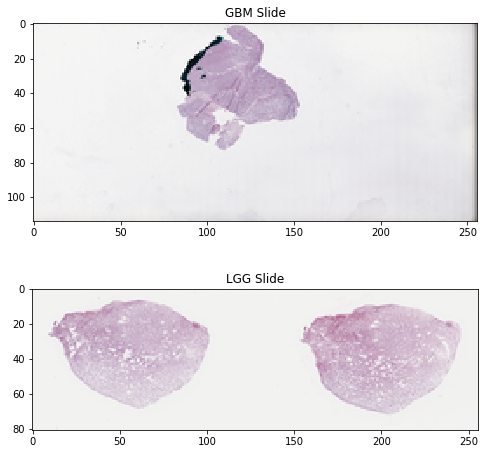

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.title('GBM Slide')
plt.imshow(get_img('gbm',20))
plt.subplot(2,1,2)
plt.title('LGG Slide')
plt.imshow(get_img('lgg',20))

In [17]:
lgg = pd.read_pickle('../tcga/dense_features/lgg_features_v1.pkl')

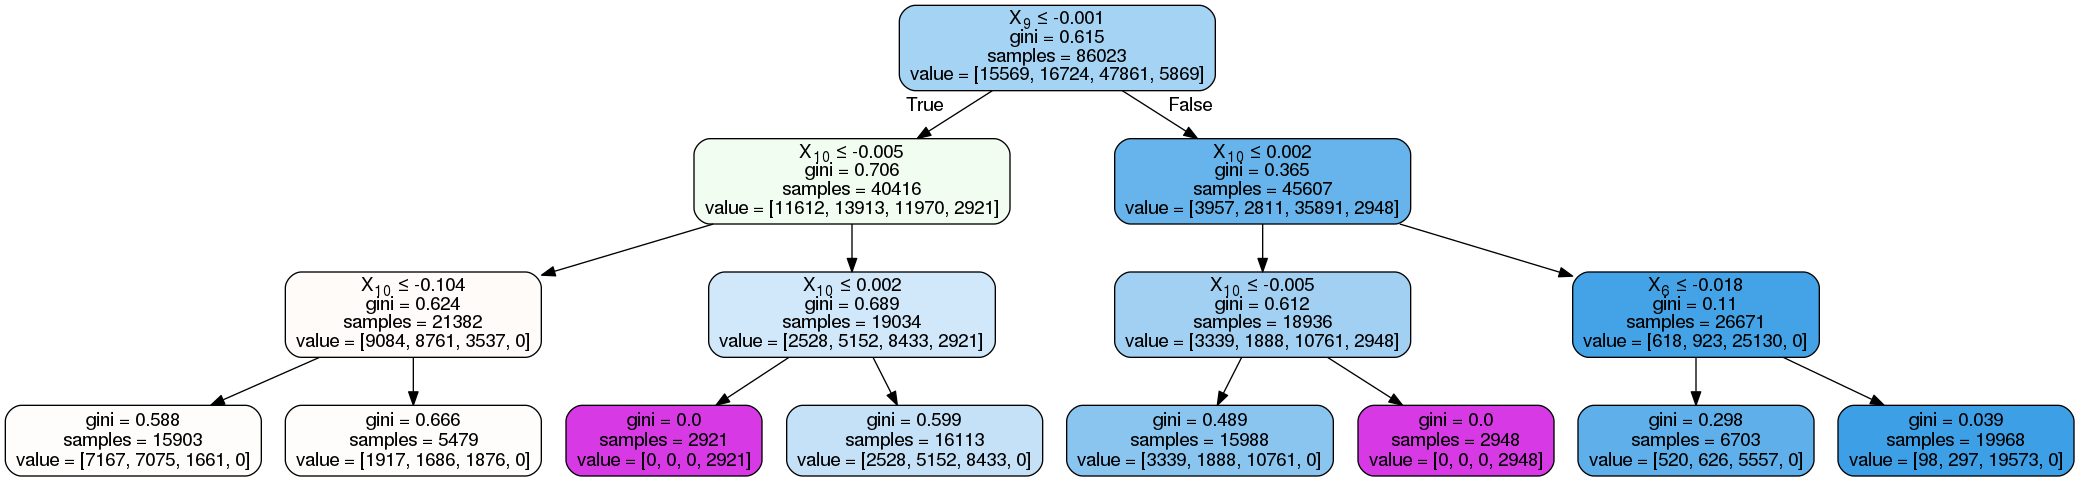

In [18]:
dtree = clfs['Decision tree, depth 3']
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())